# $S_E/T$ - Full computation: Checks and grid

## Initial set up

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys 
sys.path.append("../src/RGE")

%run ../startup.py


📊 Plot style: using ps.apply_standard_formatting
✅ startup.py loaded: numpy, scipy, matplotlib, and project modules are ready.
   Use new_figure() to create pre-formatted plots.


In [11]:
# Paso 1: crear Veff con la ruta explícita
veff_obj = veff.VeffRGE(vt_table_path="../VT_integralNumeric.dat")

# Paso 2: pasarlo explícitamente al solver
solver = bs_full.BounceSolver(veff=veff_obj)

## Checking $S_E$ works properly

In [10]:
# === Parameters ===
gD0 = 0.8
scale = np.pi
ls0 = 1e-10
T_vals = np.logspace(-5, np.log10(0.3), 50)  # ajusta rango según tu caso
S_vals = []

for T in tqdm(T_vals, desc="Computing S_E(T)"):
    try:
        S, phi_opt = solver.SE(T, gD0, scale, ls0)
        S_vals.append(S)
    except Exception as e:
        print(f"⚠️ Failed at T={T:.3e}: {e}")
        S_vals.append(np.nan)

Computing S_E(T): 100%|██████████| 50/50 [47:31<00:00, 57.03s/it]


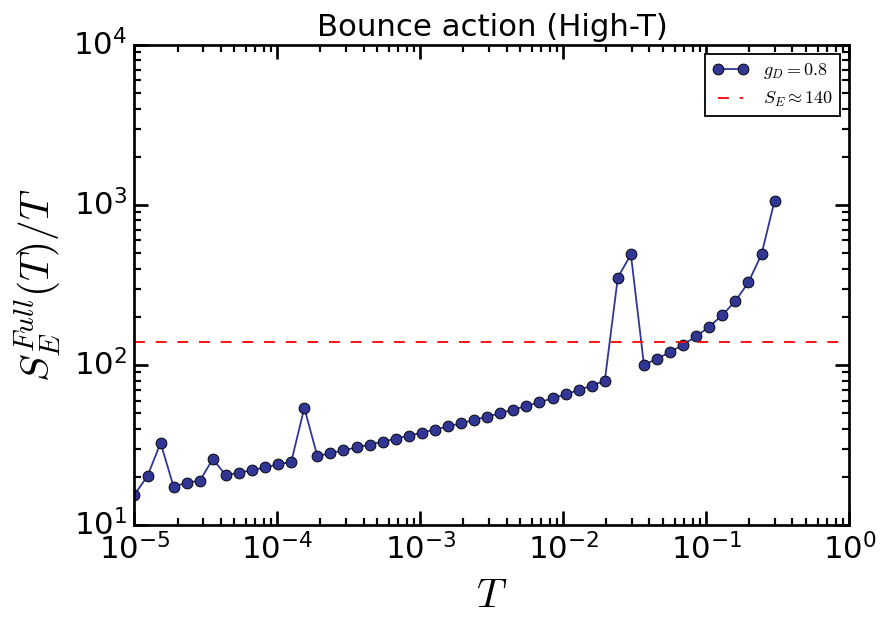

In [14]:

# === Plot with YOUR plot_style ===
fig, ax = new_figure(figsize=(7, 5), dpi=130)
fig.patch.set_facecolor('white')

ax.plot(T_vals, S_vals/T_vals,
        color=ps.colors["Full"],
        linestyle=ps.linestyles["Full"],
        marker="o",
        label=fr"$g_D={gD0}$")

# Critical line
ax.axhline(140, color="red", ls="--", label=r"$S_E \approx 140$")

# Apply your custom formatting
ps.apply_standard_formatting(ax,
                             xlabel=r"$T$",
                             ylabel=r"$S_E^{Full}(T)/T$",
                             title="Bounce action (High-T)",
                             xlog=True, ylog=True
                             )

# Legend
plt.style.use('classic')
plt.legend(loc="best", ncol=1, fontsize=10)

plt.tight_layout()
plt.show()

In [15]:
# Saving the data
data = np.column_stack((T_vals, S_vals/T_vals))
np.savetxt("../data/raw_data/S_full_RGE_gD_0_8_mu_piT_ls0_1e-10.dat", data, header="T  S", comments='')

## Generating $S_E$ grid

In [ ]:

# === Grid parameters ===
Tmax = np.log10(0.35)
T_vals = np.logspace(-4, Tmax, 50)         # 50 puntos en T
gD_vals = np.linspace(0.6, 1.0, 25)        # 25 puntos en gD

S_log_grid = np.empty((len(T_vals), len(gD_vals)))
S_log_grid[:] = np.nan  # inicializar con NaN

# === Loop ===
for i, T in enumerate(tqdm(T_vals, desc="Temperatura")):
    for j, gD in enumerate(gD_vals):
        try:
            S_val, phi_opt = solver_ht.SE(T, gD)  # tu función actual
            if S_val > 0 and np.isfinite(S_val):
                S_log_grid[i, j] = np.log10(S_val)
        except Exception as e:
            # puedes activar debug si quieres ver los fallos
            # print(f"⚠️ Failed at T={T:.3e}, gD={gD:.3f}: {e}")
            pass

# === Optional: save grid ===
np.savez("../data/raw_data/SE_RGE_log_grid_Full_2piT.npz",
         S_log_grid=S_log_grid,
         T_vals=T_vals,
         gD_vals=gD_vals)


### Cleaning greed

In [ ]:
data = np.load("../data/raw_data/SE_RGE_log_grid_Full_2piT.npz")
S_log_grid = data["S_log_grid"]
T_vals = data["T_vals"]
gD_vals = data["gD_vals"]

In [ ]:
# === Paso 1: cargar la curva para un j fijo ===
j = 12 # o el índice gD que elijas
logS_vals = S_log_grid[:, j]  # esta es la columna de log10(S)
T_this = T_vals              # los T son iguales siempre

# === Paso 2: visualizar con índice de cada punto ===
plt.figure(figsize=(8, 5))
for i, (T, logS) in enumerate(zip(T_this, logS_vals)):
    plt.plot(T, logS, 'o', color='black')
    plt.text(T, logS + 0.05, str(i), fontsize=8, ha='center', va='bottom', color='crimson')  # muestra el índice i

plt.xscale('log')
plt.xlabel(r'$T$ [GeV]', fontsize=14)
plt.ylabel(r'$\log_{10}(S_3)$', fontsize=14)
plt.title(fr'$g_D = {gD_vals[j]:.3f}$', fontsize=15)
#plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# Creamos una copia para trabajar
logS_cleaned = S_log_grid.copy()

# Remover el punto específico (por índice visual)
i =31# el que viste en el plot
logS_cleaned[i, j] = np.nan  # lo marcamos como nan
S_log_grid[i, j] = logS_cleaned[i, j]

In [ ]:
# Guarda el grid junto con los ejes
np.savez_compressed("../data/cleaned_data/SE_RGE_log_grid_Full_2piT_cleaned.npz.npz", 
                    S_log_grid=S_log_grid, 
                    T_vals=T_vals, 
                    gD_vals=gD_vals)

## Final plots of $S_E$-interpolation